In [16]:
from time import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
nltk.download('stopwords')
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(nltk.corpus.stopwords.words("english"))
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yjunwoo14/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


데이터 살펴보기

In [17]:
## Read the train and test dataset and check the top few lines ##
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_x.csv')
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

Number of rows in train dataset :  54879
Number of rows in test dataset :  19617


In [18]:
train_df.head()

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [19]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name :  0
'You were not here last Sunday night,' he said.
I had scant luggage to take with me to London, for little of the little I possessed was adapted to my new station. But I began packing that same afternoon, and wildly packed up things that I knew I should want next morning, in a fiction that there was not a moment to be lost.
‘Why, the fact is,’ returned odin, ‘Mr. odin had so completely hemmed him in, and was always ready with so many new points if an old one failed, that he could not escape from us. A most remarkable circumstance is, that I really don’t think he grasped this sum even so much for the gratification of his avarice, which was inordinate, as in the hatred he felt for odin. He said so to me, plainly. He said he would even have spent as much, to baulk or injure odin.’
Dora was delighted with the little presents, and kissed me joyfully; but there was a shadow between us, however slight, and I had made up my mind that it should not be there. If there must be suc

위를 특정 단어와 보면 아시겠지만 특정 글쓰기 스타일이 문장에서 나타나는 특정 단어와 문장부호 빈도횟수와 관련이 깊을 것 같아 feature로 만들게 되었습니다. 훈련결과 유무의 차이는 되게 컸습니다. 

**Feature Engineering:**

크게 메타 피쳐와 텍스트 기반 피쳐로 나눌 수 있습니다 

1. 메타 피쳐 - stopword 갯수, 단어갯수, 문장부호 갯수 등 텍스트에서 뽑아낸 피쳐라 할 수 있습니다.

2. 텍스트 기반 피쳐 - 단어 등장 빈도수, word2vec 같이 문장 그 자체에서 추출한 피쳐라 볼 수 있습니다



In [20]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

##additional
train_df[","] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(",")]))
test_df[","] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(",")]))

train_df[";"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(";")]))
test_df[";"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(";")]))

train_df['\"'] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split('\"')]))
test_df['\"'] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split('\"')]))

train_df["..."] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("...")]))
test_df["..."] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("...")]))

train_df["?"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("?")]))
test_df["?"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("?")]))

train_df["!"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("!")]))
test_df["!"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("!")]))

train_df["."] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(".")]))
test_df["."] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(".")]))

train_df[":"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(":")]))
test_df[":"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(":")]))

train_df["*"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("*")]))
test_df["*"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("*")]))

train_df["-"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("-")]))
test_df["-"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("-")]))

train_df["n_The"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("The ")]))
test_df["n_The"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("The ")]))

train_df["n_a"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("a ")]))
test_df["n_a"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("a ")]))

train_df["n_I"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("I ")]))
test_df["n_I"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("I ")]))

train_df["n_It"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("It ")]))
test_df["n_It"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("It ")]))

train_df["n_He"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("He ")]))
test_df["n_He"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("He ")]))

train_df["n_She"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("She ")]))
test_df["n_She"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("She ")]))

train_df["n_Me"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("Me ")]))
test_df["n_Me"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("Me ")]))

train_df["n_You"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("You ")]))
test_df["n_You"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("You ")]))


glove 인덱스를 사용해 sent2vec 임베딩을 시행하고 이를 feature로 추가시킵니다


In [ ]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip

In [26]:
import tqdm
from nltk import word_tokenize

def load_glove_index():
    EMBEDDING_FILE = 'glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    return embeddings_index

embeddings_index = load_glove_index()

print('Found %s word vectors.' % len(embeddings_index))

def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in eng_stopwords]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

# create glove features
xtrain_glove = np.array([sent2vec(x) for x in tqdm.tqdm(train_df.text)])
xtest_glove = np.array([sent2vec(x) for x in tqdm.tqdm(test_df.text)])

train_df = pd.concat([train_df, pd.DataFrame(xtrain_glove)], axis=1)
test_df = pd.concat([test_df, pd.DataFrame(xtest_glove)], axis=1)

  0%|          | 161/54879 [00:00<00:34, 1604.30it/s]

Found 2196017 word vectors.


100%|██████████| 19617/19617 [00:19<00:00, 1023.68it/s]


In [27]:
## Prepare the data for modeling ###
train_y = train_df['author']
train_id = train_df['index'].values
test_id = test_df['index'].values

cols_to_drop = ['index', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [28]:
test_X

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,",",;,...,290,291,292,293,294,295,296,297,298,299
0,89,68,456,49,9,5,9,4.134831,113.250000,456.0,...,-0.044960,0.011610,-0.028244,-0.010563,0.019708,0.022045,0.008051,0.012932,0.009066,0.008632
1,43,36,221,21,20,5,5,4.162791,26.750000,110.0,...,-0.038617,0.012395,-0.036131,0.003752,0.064445,0.012249,-0.000085,0.010356,0.018096,0.036173
2,64,55,375,32,10,0,2,4.875000,52.714286,375.0,...,-0.042617,-0.004495,0.034471,-0.002403,-0.040440,0.045412,0.024801,0.035259,0.023476,-0.012943
3,240,150,1218,121,28,11,21,4.079167,75.187500,608.5,...,-0.049928,0.003576,0.031425,-0.027412,-0.014217,0.038402,0.020883,0.041368,0.003595,-0.006382
4,91,71,510,44,13,4,8,4.615385,84.166667,510.0,...,-0.044240,-0.000206,-0.019059,-0.020567,0.012233,0.020320,0.024884,0.024358,0.011092,-0.007385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19612,154,98,861,71,29,1,10,4.597403,60.571429,214.5,...,-0.056781,0.001329,-0.009585,0.005443,0.005825,0.003854,0.013896,-0.016797,0.001109,-0.012753
19613,258,162,1377,137,39,5,15,4.341085,56.416667,343.5,...,-0.044407,-0.003236,0.010879,0.003318,0.011243,0.036185,-0.006347,0.020872,0.000979,-0.001350
19614,59,44,320,35,9,0,3,4.423729,52.500000,159.5,...,-0.063882,0.014277,0.007952,0.012563,0.021601,-0.022301,0.004222,-0.000532,-0.025269,-0.019011
19615,63,59,347,30,15,3,9,4.523810,57.000000,347.0,...,-0.072967,0.025909,-0.027639,-0.018688,0.028033,-0.009834,0.012142,-0.004417,0.000578,-0.007101


XGBoost 모델과 kfold 교차검증을 통해 1차적으로 계산해봅니다

In [29]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 5
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model


In [30]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[10:38:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.59305	test-mlogloss:1.59429
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.40349	test-mlogloss:1.42006
[40]	train-mlogloss:1.31154	test-mlogloss:1.33793
[60]	train-mlogloss:1.25085	test-mlogloss:1.28523
[80]	train-mlogloss:1.20333	test-mlogloss:1.24549
[100]	train-mlogloss:1.16744	test-mlogloss:1.21672
[120]	train-mlogloss:1.13608	test-mlogloss:1.19215
[140]	train-mlogloss:1.10828	test-mlogloss:1.17070
[160]	train-mlogloss:1.08342	test-mlogloss:1.15215
[18

메타 피쳐만 사용해 mlogloss '0.943'이 나왔고 나쁘지 않은 결과입니다. 피쳐 중요로를 보자면 아래와 같습니다 

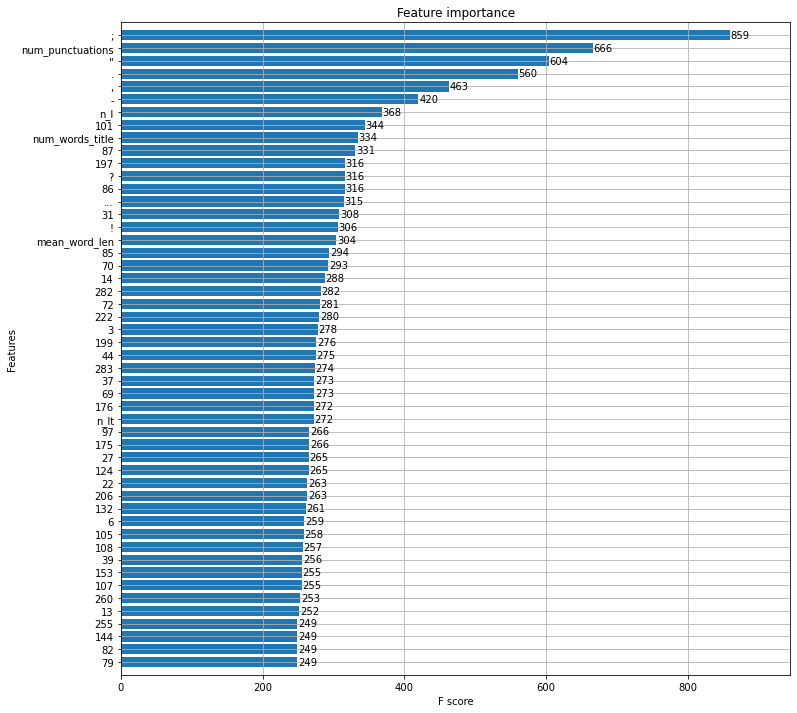

In [31]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

세미콜론 갯수, 문장부호 갯수, 따옴표 갯수 3개가 중요도 순위 탑3에 드는 걸 보실 수 있습니다.

**텍스트 기반 피쳐 :**

tf-idf 값을 통해 피쳐를 생성해보겠습니다.
모델로는 총 10가지 모델을 실험해본 결과 naive bayes의 multinomial의 isotonic모델이 가장빠르면서도 정확했고 그 다음으로는 bernoulli, sgd랑 passive aggressive 세 모델이 속도/정확도 측면에서 좋아 고르게 되었습니다.

모델선택과 하이퍼파라미터 튜닝 코드는 후에 정리하여 따로 올려보도록 하겠습니다.

In [32]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [44]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier, LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier 
from sklearn.ensemble import VotingClassifier

def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = CalibratedClassifierCV(MultinomialNB(alpha=0.03), method='isotonic')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

def runBER(train_X, train_y, test_X, test_y, test_X2):
    model = CalibratedClassifierCV(BernoulliNB(alpha=0.03), method='isotonic')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

def runSGD(train_X, train_y, test_X, test_y, test_X2):
    model = CalibratedClassifierCV(SGDClassifier(loss='modified_huber', alpha=1e-4, tol=1e-5, 
                                                 penalty='elasticnet'), method='sigmoid')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

def runPAS(train_X, train_y, test_X, test_y, test_X2):
    model = CalibratedClassifierCV(PassiveAggressiveClassifier(C=1e-2, tol=1e-3), method='isotonic')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [34]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.7094077833055591


In [35]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runBER(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.9208806591031429


In [36]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runSGD(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.847205523948354


In [39]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runPAS(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.7712206197146423


linearsvc와 ridge는 정확도는 괜찮지만 대량 데이터 처리하기엔 계산 속도가 너무 느려 제외하였습니다.

In [49]:
from sklearn.svm import LinearSVC

In [51]:
def runPAS1(train_X, train_y, test_X, test_y, test_X2):
    model = CalibratedClassifierCV(LinearSVC(C=2, penalty='l1', max_iter=2000, dual=False),
                                   method='isotonic')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runPAS1(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Mean cv score :  0.7949828832410619


In [53]:
def runPAS2(train_X, train_y, test_X, test_y, test_X2):
    model = CalibratedClassifierCV(RidgeClassifier(alpha=1e0, solver='sag', tol=1e-3, max_iter=2000), method='isotonic')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runPAS2(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.7799920747142567


모덱 성능 확인을 위한 confusion matrix를 계산하는 코드입니다.
모델별 따로 확인하였으며 참고용으로 남겨놓습니다.

In [54]:
### Function to create confusion matrix ###
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**SVD와 TFIDF:**

tfidf 벡터는 분산되어있기에 특이값분해(svd)를 통해 정보를 함축하여 피쳐를 생성해보겠습니다. word tfidf에 svd를 적용시켰고 대각선 특이값 상위20개를 사용하였습니다 (n_comp)

자세한 설명 및 참조
https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/04/06/pcasvdlsa/


In [56]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

이번엔 countervectorizer을 사용해 4가지 모델로 피쳐를 추가하겠습니다.
또한 다양한 단위로 토큰화 해보았습니다(char, char_wb, word)

In [57]:
### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [58]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.
# add the predictions as new features #
train_df["nb_word2_0"] = pred_train[:,0]
train_df["nb_word2_1"] = pred_train[:,1]
train_df["nb_word2_2"] = pred_train[:,2]
train_df["nb_word2_3"] = pred_train[:,3]
train_df["nb_word2_4"] = pred_train[:,4]


test_df["nb_word2_0"] = pred_full_test[:,0]
test_df["nb_word2_1"] = pred_full_test[:,1]
test_df["nb_word2_2"] = pred_full_test[:,2]
test_df["nb_word2_3"] = pred_full_test[:,3]
test_df["nb_word2_4"] = pred_full_test[:,4]

Mean cv score :  0.7335224993074444


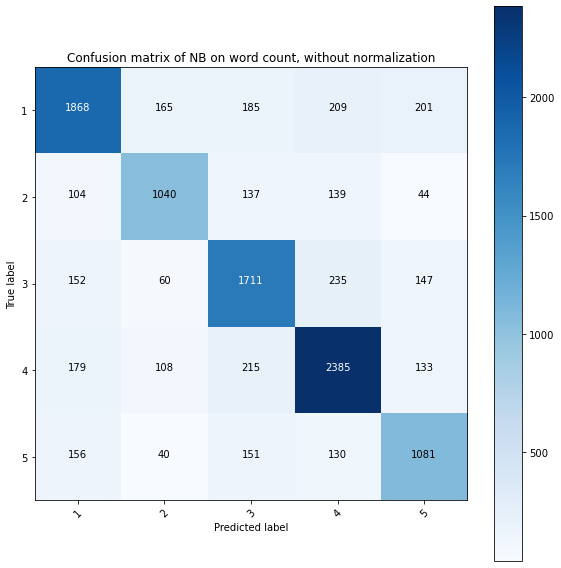

In [59]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['1', '2', '3', '4', '5'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

In [60]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runBER(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.
# add the predictions as new features #
train_df["ber_word2_0"] = pred_train[:,0]
train_df["ber_word2_1"] = pred_train[:,1]
train_df["ber_word2_2"] = pred_train[:,2]
train_df["ber_word2_3"] = pred_train[:,3]
train_df["ber_word2_4"] = pred_train[:,4]


test_df["ber_word2_0"] = pred_full_test[:,0]
test_df["ber_word2_1"] = pred_full_test[:,1]
test_df["ber_word2_2"] = pred_full_test[:,2]
test_df["ber_word2_3"] = pred_full_test[:,3]
test_df["ber_word2_4"] = pred_full_test[:,4]


Mean cv score :  0.9208806591031429


In [61]:

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runSGD(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test /= 5

train_df["em_word2_0"] = pred_train[:,0]
train_df["em_word2_1"] = pred_train[:,1]
train_df["em_word2_2"] = pred_train[:,2]
train_df["em_word2_3"] = pred_train[:,3]
train_df["em_word2_4"] = pred_train[:,4]


test_df["em_word2_0"] = pred_full_test[:,0]
test_df["em_word2_1"] = pred_full_test[:,1]
test_df["em_word2_2"] = pred_full_test[:,2]
test_df["em_word2_3"] = pred_full_test[:,3]
test_df["em_word2_4"] = pred_full_test[:,4]

cv scores :  [0.7471266026168288]


In [62]:

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runPAS(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test /= 5

train_df["pas_word2_0"] = pred_train[:,0]
train_df["pas_word2_1"] = pred_train[:,1]
train_df["pas_word2_2"] = pred_train[:,2]
train_df["pas_word2_3"] = pred_train[:,3]
train_df["pas_word2_4"] = pred_train[:,4]


test_df["pas_word2_0"] = pred_full_test[:,0]
test_df["pas_word2_1"] = pred_full_test[:,1]
test_df["pas_word2_2"] = pred_full_test[:,2]
test_df["pas_word2_3"] = pred_full_test[:,3]
test_df["pas_word2_4"] = pred_full_test[:,4]

cv scores :  [0.7986616905935812]


In [63]:
tfidf_vec = CountVectorizer(analyzer='char_wb', ngram_range=(1, 5))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_c2_0"] = pred_train[:,0]
train_df["nb_c2_1"] = pred_train[:,1]
train_df["nb_c2_2"] = pred_train[:,2]
train_df["nb_c2_3"] = pred_train[:,3]
train_df["nb_c2_4"] = pred_train[:,4]


test_df["nb_c2_0"] = pred_full_test[:,0]
test_df["nb_c2_1"] = pred_full_test[:,1]
test_df["nb_c2_2"] = pred_full_test[:,2]
test_df["nb_c2_3"] = pred_full_test[:,3]
test_df["nb_c2_4"] = pred_full_test[:,4]


/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


Mean cv score :  0.6309694490244755


In [64]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runBER(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["ber_c2_0"] = pred_train[:,0]
train_df["ber_c2_1"] = pred_train[:,1]
train_df["ber_c2_2"] = pred_train[:,2]
train_df["ber_c2_3"] = pred_train[:,3]
train_df["ber_c2_4"] = pred_train[:,4]


test_df["ber_c2_0"] = pred_full_test[:,0]
test_df["ber_c2_1"] = pred_full_test[:,1]
test_df["ber_c2_2"] = pred_full_test[:,2]
test_df["ber_c2_3"] = pred_full_test[:,3]
test_df["ber_c2_4"] = pred_full_test[:,4]


/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/cal

Mean cv score :  0.8699746560796363


In [65]:

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runSGD(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test /= 5

train_df["em_c2_0"] = pred_train[:,0]
train_df["em_c2_1"] = pred_train[:,1]
train_df["em_c2_2"] = pred_train[:,2]
train_df["em_c2_3"] = pred_train[:,3]
train_df["em_c2_4"] = pred_train[:,4]


test_df["em_c2_0"] = pred_full_test[:,0]
test_df["em_c2_1"] = pred_full_test[:,1]
test_df["em_c2_2"] = pred_full_test[:,2]
test_df["em_c2_3"] = pred_full_test[:,3]
test_df["em_c2_4"] = pred_full_test[:,4]

cv scores :  [0.690215080159552]


In [66]:

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runPAS(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test /= 5

train_df["pas_c2_0"] = pred_train[:,0]
train_df["pas_c2_1"] = pred_train[:,1]
train_df["pas_c2_2"] = pred_train[:,2]
train_df["pas_c2_3"] = pred_train[:,3]
train_df["pas_c2_4"] = pred_train[:,4]


test_df["pas_c2_0"] = pred_full_test[:,0]
test_df["pas_c2_1"] = pred_full_test[:,1]
test_df["pas_c2_2"] = pred_full_test[:,2]
test_df["pas_c2_3"] = pred_full_test[:,3]
test_df["pas_c2_4"] = pred_full_test[:,4]

cv scores :  [0.6699686492041655]


In [72]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())


In [73]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_0"] = pred_train[:,0]
train_df["nb_cvec_char_1"] = pred_train[:,1]
train_df["nb_cvec_char_2"] = pred_train[:,2]
train_df["nb_cvec_char_3"] = pred_train[:,3]
train_df["nb_cvec_char_4"] = pred_train[:,4]


test_df["nb_cvec_char_0"] = pred_full_test[:,0]
test_df["nb_cvec_char_1"] = pred_full_test[:,1]
test_df["nb_cvec_char_2"] = pred_full_test[:,2]
test_df["nb_cvec_char_3"] = pred_full_test[:,3]
test_df["nb_cvec_char_4"] = pred_full_test[:,4]


/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


Mean cv score :  0.5077755827270963


In [74]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runBER(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["ber_cvec_char_0"] = pred_train[:,0]
train_df["ber_cvec_char_1"] = pred_train[:,1]
train_df["ber_cvec_char_2"] = pred_train[:,2]
train_df["ber_cvec_char_3"] = pred_train[:,3]
train_df["ber_cvec_char_4"] = pred_train[:,4]


test_df["ber_cvec_char_0"] = pred_full_test[:,0]
test_df["ber_cvec_char_1"] = pred_full_test[:,1]
test_df["ber_cvec_char_2"] = pred_full_test[:,2]
test_df["ber_cvec_char_3"] = pred_full_test[:,3]
test_df["ber_cvec_char_4"] = pred_full_test[:,4]

/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/cal

Mean cv score :  0.7269403269768862


/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


In [75]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runSGD(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test /= 5

train_df["em_cvec_char_0"] = pred_train[:,0]
train_df["em_cvec_char_1"] = pred_train[:,1]
train_df["em_cvec_char_2"] = pred_train[:,2]
train_df["em_cvec_char_3"] = pred_train[:,3]
train_df["em_cvec_char_4"] = pred_train[:,4]


test_df["em_cvec_char_0"] = pred_full_test[:,0]
test_df["em_cvec_char_1"] = pred_full_test[:,1]
test_df["em_cvec_char_2"] = pred_full_test[:,2]
test_df["em_cvec_char_3"] = pred_full_test[:,3]
test_df["em_cvec_char_4"] = pred_full_test[:,4]

cv scores :  [0.5885048174337305]


In [76]:

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runPAS(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test /= 5

train_df["pas_cvec_char_0"] = pred_train[:,0]
train_df["pas_cvec_char_1"] = pred_train[:,1]
train_df["pas_cvec_char_2"] = pred_train[:,2]
train_df["pas_cvec_char_3"] = pred_train[:,3]
train_df["pas_cvec_char_4"] = pred_train[:,4]


test_df["pas_cvec_char_0"] = pred_full_test[:,0]
test_df["pas_cvec_char_1"] = pred_full_test[:,1]
test_df["pas_cvec_char_2"] = pred_full_test[:,2]
test_df["pas_cvec_char_3"] = pred_full_test[:,3]
test_df["pas_cvec_char_4"] = pred_full_test[:,4]

/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


cv scores :  [0.5565386542286499]


/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


이번엔 tfidf벡터에 character, word단위로 토큰화 하였습니다.

In [92]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())


In [93]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_0"] = pred_train[:,0]
train_df["nb_tfidf_char_1"] = pred_train[:,1]
train_df["nb_tfidf_char_2"] = pred_train[:,2]
train_df["nb_tfidf_char_3"] = pred_train[:,3]
train_df["nb_tfidf_char_4"] = pred_train[:,4]


test_df["nb_tfidf_char_0"] = pred_full_test[:,0]
test_df["nb_tfidf_char_1"] = pred_full_test[:,1]
test_df["nb_tfidf_char_2"] = pred_full_test[:,2]
test_df["nb_tfidf_char_3"] = pred_full_test[:,3]
test_df["nb_tfidf_char_4"] = pred_full_test[:,4]

Mean cv score :  0.5531638992409433


In [94]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runBER(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["ber_tfidf_char_0"] = pred_train[:,0]
train_df["ber_tfidf_char_1"] = pred_train[:,1]
train_df["ber_tfidf_char_2"] = pred_train[:,2]
train_df["ber_tfidf_char_3"] = pred_train[:,3]
train_df["ber_tfidf_char_4"] = pred_train[:,4]

test_df["ber_tfidf_char_0"] = pred_full_test[:,0]
test_df["ber_tfidf_char_1"] = pred_full_test[:,1]
test_df["ber_tfidf_char_2"] = pred_full_test[:,2]
test_df["ber_tfidf_char_3"] = pred_full_test[:,3]
test_df["ber_tfidf_char_4"] = pred_full_test[:,4]

/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/cal

Mean cv score :  0.8815264878801748


/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


In [95]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runSGD(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test /= 5

train_df["em_tfidf_char_0"] = pred_train[:,0]
train_df["em_tfidf_char_1"] = pred_train[:,1]
train_df["em_tfidf_char_2"] = pred_train[:,2]
train_df["em_tfidf_char_3"] = pred_train[:,3]
train_df["em_tfidf_char_4"] = pred_train[:,4]


test_df["em_tfidf_char_0"] = pred_full_test[:,0]
test_df["em_tfidf_char_1"] = pred_full_test[:,1]
test_df["em_tfidf_char_2"] = pred_full_test[:,2]
test_df["em_tfidf_char_3"] = pred_full_test[:,3]
test_df["em_tfidf_char_4"] = pred_full_test[:,4]

cv scores :  [0.5838937059936298]


In [96]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runPAS(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test /= 5

train_df["pas_tfidf_char_0"] = pred_train[:,0]
train_df["pas_tfidf_char_1"] = pred_train[:,1]
train_df["pas_tfidf_char_2"] = pred_train[:,2]
train_df["pas_tfidf_char_3"] = pred_train[:,3]
train_df["pas_tfidf_char_4"] = pred_train[:,4]


test_df["pas_tfidf_char_0"] = pred_full_test[:,0]
test_df["pas_tfidf_char_1"] = pred_full_test[:,1]
test_df["pas_tfidf_char_2"] = pred_full_test[:,2]
test_df["pas_tfidf_char_3"] = pred_full_test[:,3]
test_df["pas_tfidf_char_4"] = pred_full_test[:,4]

cv scores :  [0.5402619663712201]


In [97]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='word')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [98]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf2_char_0"] = pred_train[:,0]
train_df["nb_tfidf2_char_1"] = pred_train[:,1]
train_df["nb_tfidf2_char_2"] = pred_train[:,2]
train_df["nb_tfidf2_char_3"] = pred_train[:,3]
train_df["nb_tfidf2_char_4"] = pred_train[:,4]


test_df["nb_tfidf2_char_0"] = pred_full_test[:,0]
test_df["nb_tfidf2_char_1"] = pred_full_test[:,1]
test_df["nb_tfidf2_char_2"] = pred_full_test[:,2]
test_df["nb_tfidf2_char_3"] = pred_full_test[:,3]
test_df["nb_tfidf2_char_4"] = pred_full_test[:,4]

Mean cv score :  0.6318024197153005


In [99]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runBER(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["ber_tfidf2_char_0"] = pred_train[:,0]
train_df["ber_tfidf2_char_1"] = pred_train[:,1]
train_df["ber_tfidf2_char_2"] = pred_train[:,2]
train_df["ber_tfidf2_char_3"] = pred_train[:,3]
train_df["ber_tfidf2_char_4"] = pred_train[:,4]

test_df["ber_tfidf2_char_0"] = pred_full_test[:,0]
test_df["ber_tfidf2_char_1"] = pred_full_test[:,1]
test_df["ber_tfidf2_char_2"] = pred_full_test[:,2]
test_df["ber_tfidf2_char_3"] = pred_full_test[:,3]
test_df["ber_tfidf2_char_4"] = pred_full_test[:,4]

/home/yjunwoo14/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


Mean cv score :  1.0060505981770482


In [100]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runSGD(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test /= 5

train_df["em_tfidf2_char_0"] = pred_train[:,0]
train_df["em_tfidf2_char_1"] = pred_train[:,1]
train_df["em_tfidf2_char_2"] = pred_train[:,2]
train_df["em_tfidf2_char_3"] = pred_train[:,3]
train_df["em_tfidf2_char_4"] = pred_train[:,4]


test_df["em_tfidf2_char_0"] = pred_full_test[:,0]
test_df["em_tfidf2_char_1"] = pred_full_test[:,1]
test_df["em_tfidf2_char_2"] = pred_full_test[:,2]
test_df["em_tfidf2_char_3"] = pred_full_test[:,3]
test_df["em_tfidf2_char_4"] = pred_full_test[:,4]

cv scores :  [0.8342656990766656]


In [101]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runPAS(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test /= 5

train_df["pas_tfidf2_char_0"] = pred_train[:,0]
train_df["pas_tfidf2_char_1"] = pred_train[:,1]
train_df["pas_tfidf2_char_2"] = pred_train[:,2]
train_df["pas_tfidf2_char_3"] = pred_train[:,3]
train_df["pas_tfidf2_char_4"] = pred_train[:,4]


test_df["pas_tfidf2_char_0"] = pred_full_test[:,0]
test_df["pas_tfidf2_char_1"] = pred_full_test[:,1]
test_df["pas_tfidf2_char_2"] = pred_full_test[:,2]
test_df["pas_tfidf2_char_3"] = pred_full_test[:,3]
test_df["pas_tfidf2_char_4"] = pred_full_test[:,4]

cv scores :  [0.6962527520998825]


**SVD와 Character TFIDF:**

character tfidf을 사용해 svd 피쳐를 만들었습니다.

In [102]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

**Ensemble model:**

여러 모델들을 앙상블 해보았습니다.
원래는 위에서도 4가지 모델에 추가로 앙상블까지 하려했지만 계산시간이 너무 길어져 feature 1개만 만들게 되었습니다

In [103]:
models = [('MultiNB', MultinomialNB(alpha=0.03)),
          ('Calibrated MultiNB', CalibratedClassifierCV(
              MultinomialNB(alpha=0.03), method='isotonic')),
          ('Calibrated BernoulliNB', CalibratedClassifierCV(
              BernoulliNB(alpha=0.03), method='isotonic')),
          ('Calibrated Huber', CalibratedClassifierCV(
              SGDClassifier(loss='modified_huber', alpha=1e-4,
                            max_iter=2000, tol=1e-5, penalty='elasticnet'), method='sigmoid')),
          ('Logit', LogisticRegression(C=30, max_iter = 2000))]

vectorizer=TfidfVectorizer(token_pattern=r'\w{1,}', sublinear_tf=True, ngram_range=(1,2))
clf = VotingClassifier(models, voting='soft', weights=[3,3,3,1,1])

X_train = vectorizer.fit_transform(train_df.text.values)
y_train = train_df['author']
X_test = vectorizer.transform(test_df.text.values)

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = X_train[dev_index], X_train[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    clf.fit(dev_X, dev_y)
    pred_val_y = clf.predict_proba(val_X)
    pred_full_test = pred_full_test + clf.predict_proba(X_test)
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test /= 5

train_df["mix_tfidf_0"] = pred_train[:,0]
train_df["mix_tfidf_1"] = pred_train[:,1]
train_df["mix_tfidf_2"] = pred_train[:,2]
train_df["mix_tfidf_3"] = pred_train[:,3]
train_df["mix_tfidf_4"] = pred_train[:,4]


test_df["mix_tfidf_0"] = pred_full_test[:,0]
test_df["mix_tfidf_1"] = pred_full_test[:,1]
test_df["mix_tfidf_2"] = pred_full_test[:,2]
test_df["mix_tfidf_3"] = pred_full_test[:,3]
test_df["mix_tfidf_4"] = pred_full_test[:,4]

cv scores :  [0.5768279816080424]


새롭게 만든 feature들을 이용하여 XGBoost를 돌려보겠습니다 

In [114]:
cols_to_drop = ['index', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['0', '1', '2','3', '4']
out_df.insert(0, 'index', test_id)
out_df.to_csv("dacon_submission.csv", index=False)

[10:14:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.44290	test-mlogloss:1.44302
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.53541	test-mlogloss:0.53707
[40]	train-mlogloss:0.42600	test-mlogloss:0.43253
[60]	train-mlogloss:0.39264	test-mlogloss:0.40545
[80]	train-mlogloss:0.37289	test-mlogloss:0.39273
[100]	train-mlogloss:0.35764	test-mlogloss:0.38477
[120]	train-mlogloss:0.34521	test-mlogloss:0.37958
[140]	train-mlogloss:0.33461	test-mlogloss:0.37608
[160]	train-mlogloss:0.32481	test-mlogloss:0.37347
[18

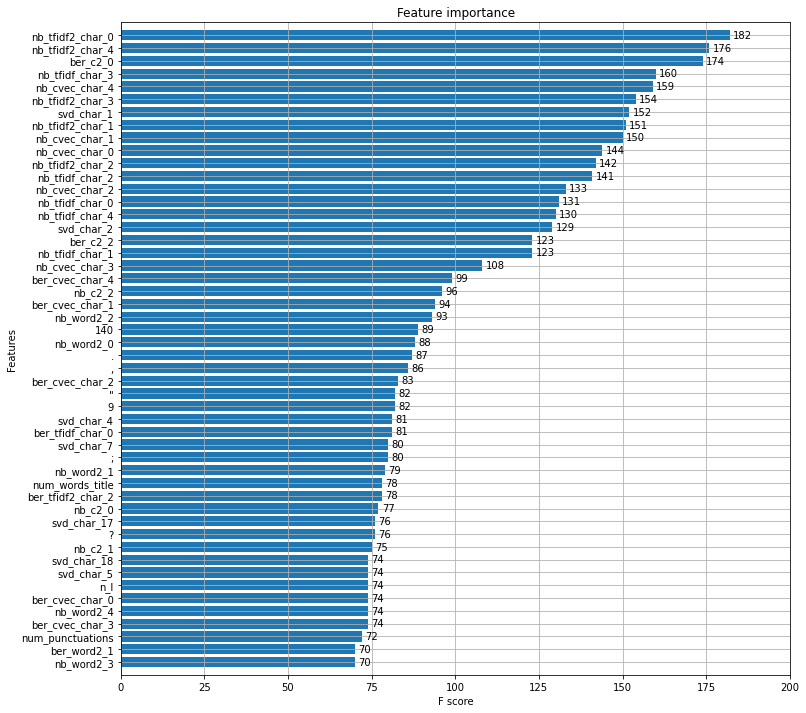

In [115]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

중요도를 보면 tfidf벡터에 naive bayes 모델들을 사용한 것들이 훌륭한 성과를 거둔 것을 볼 수 있습니다

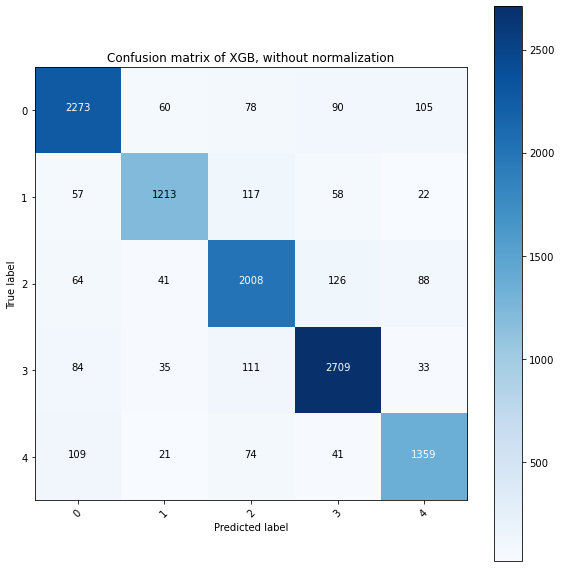

In [116]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1', '2', '3', '4'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()